# Prokudin-Gorskii Images

<p style='direction:rtl; text-align: right'>
در این تمرین برای انطباق عکس‌ها، کانال قرمز را ثابت میگیریم و سپس بهترین انطباق برای کانال‌های دیگر را روی آن پیدا میکنیم.
برای هر انطباق، ابتدا از تصویر مبدا و مقصد پیرامید گوسی میسازیم و سپس در راس پیرامید که اندازه تصاویر
در حدود ۱۰۰×۱۰۰ پیکسل است به صورت brute-force تطابق انجام میدهیم و بهترین تطابق را انتخاب میکنیم. سپس به یک طبقه پایین‌تر
در پیرامید باز میگردیم و تبدیل به دست آمده از مرحله قبلی را دقیق‌تر میکنیم؛ یعنی در حدود ۲ پیکسل در هر جهت تصویر مقصد را جرکت میدهیم
تا بهترین تطابق را پیدا کنیم.<br>
برای سنجش تطابق از Normalized Cross-Correlation استفاده میکنیم چرا که تغییر اینتنسیتی پیکسل‌های کانال های رنگی با هم هم‌بستگی دارند.
</p>

<p style='direction:rtl; text-align: right'>
ابتدا ایمپورت‌های لازم را انجام میدهیم.
</p>

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

<p style='direction:rtl; text-align: right'>
تصاویر را به صورت ۱۶بیتی از فایل میخوانیم.
</p>

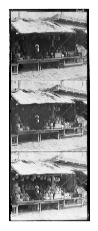

In [2]:
pic = cv.imread('./data/melons.tif', cv.IMREAD_ANYDEPTH)

plt.axis('off')
plt.imshow(pic,cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
در ادامه پیاده سازی هرم را می‌بینید. وقتی تصاویر ورودی از یک حدی کوچکتر باشند، روی آن بروت‌فورس و در غیر این صورت تنها با کمی جا به جایی آن را بهینه میکنیم.
</p>

In [3]:
def find_translation(src, tar, ratio, step_offset, min_size) -> (np.ndarray, float):
    """
    src and tar should be the same in size
    :param src: source image to find 'tar' on
    :param tar: target image to find in 'src'
    :param ratio: resize ratio of gaussian pyramid
    :param step_offset: search size on each step
    :param min_size: threshold size of image to perform brute-force search
    :return: A tuple showing how much translation should be applied to 'tar' to get 'src' plus a float showing match
        percentage
    """
    if max(src.shape + tar.shape) < min_size:
        # performing a brute-force search
        src = (src - np.mean(src)) / np.std(src)
        tar = (tar - np.mean(tar)) / np.std(tar)
        corr = signal.correlate2d(src, tar)
        offsets = np.unravel_index(np.argmax(np.abs(corr)), corr.shape)
        return offsets - np.array(tar.shape), np.amax(corr) / src.size
    else:
        # recursively solve then adjust
        kernel_size = 2 * round(1 / ratio) + 1
        sigma = 1 / ratio

        #applying gaussian filter before going up in the pyramid
        src_new = cv.GaussianBlur(src, (kernel_size, kernel_size), sigma)
        src_new = cv.resize(src_new, (0, 0), src_new, ratio, ratio, interpolation=cv.INTER_AREA)
        tar_new = cv.GaussianBlur(tar, (kernel_size, kernel_size), sigma)
        tar_new = cv.resize(tar_new, (0, 0), tar_new, ratio, ratio, interpolation=cv.INTER_AREA)

        offset, _ = find_translation(src_new, tar_new, ratio, step_offset, min_size)
        offset *= 2 # converting the answer to larger coordinates

        #Fine tuning
        mx = 0
        ind = (0, 0)

        src = (src - np.mean(src)) / np.std(src)
        tar = (tar - np.mean(tar)) / np.std(tar)
        for i_off in range(-step_offset, step_offset + 1):
            for j_off in range(-step_offset, step_offset + 1):
                t_tar = np.roll(tar, offset + (i_off, j_off), (0, 1))
                corr = abs((t_tar * src).sum())
                if corr > mx:
                    mx = corr
                    ind = (i_off, j_off)

        return offset + ind, mx

<p style='direction:rtl; text-align: right'>
حال تصویر اصلی را به سه قسمت مساوی تقسیم میکنیم تا کانال های رنگی به دست آیند.
</p>

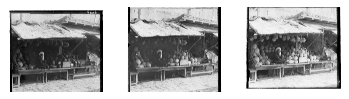

In [4]:
t_hg = pic.shape[0] // 3
pic_b = pic[0:t_hg].astype(float)
pic_g = pic[t_hg:2 * t_hg].astype(float)
pic_r = pic[2 * t_hg:t_hg * 3].astype(float)

fig, ax = plt.subplots(1,3)
for i,p in enumerate([pic_b, pic_g, pic_r]):
    ax[i].axis('off')
    ax[i].imshow(p,cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
حال الگوریتم را با نسبت کوچک سازی ۰.۵ در هرم و جا به جایی ۲ پیکسلی در هر مرحله و مینیمم سایز ۱۵۰ پیکسل انجام میدهیم.<br>
در ابتدای خروجی، میزان جا‌به‌جای کانال‌ها نوشته شده است.
</p>

----start registration of green channel
----start registration of blue channel
offset of green channel with respect to red:  [96  3]
offset of blue channel with respect to red:  [176   7]


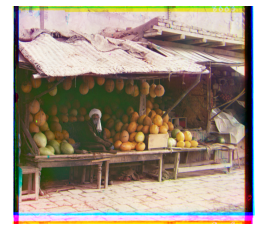

In [5]:
m_ratio = 0.5
m_step_offset = 2
m_min_size = 150

print(f'----start registration of green channel')
g_offset, _ = find_translation(pic_r.copy(), pic_g.copy(), m_ratio, m_step_offset, m_min_size)

print(f'----start registration of blue channel')
b_offset, _ = find_translation(pic_r.copy(), pic_b.copy(), m_ratio, m_step_offset, m_min_size)

pic_g = np.roll(pic_g, g_offset, (0, 1))
pic_b = np.roll(pic_b, b_offset, (0, 1))

pic_res = np.stack((pic_b / 256, pic_g / 256, pic_r / 256), axis=2).astype(np.uint8)

print('offset of green channel with respect to red: ', -g_offset)
print('offset of blue channel with respect to red: ', -b_offset)

cv.imwrite('./out/res04.jpg', pic_res)

plt.axis('off')
plt.imshow(cv.cvtColor(pic_res,cv.COLOR_BGR2RGB))
plt.show()